In [ ]:
import sys
sys.path.append('..')

# Viterbi BER Test

* Plot BER curves for Viterbi coding

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

viterbi = {}
viterbi_soft = {}

In [3]:
from ber_utils import *
from viterbi_cxxrtl_tb import *

----

## Viterbi Encoding

In [4]:
from convolutionalcodes.convolutional_encode import ConvolutionalCoderSoftware

In [5]:
def viterbi_encode(data, k=3):
    g1 = {3: 0b111, 4: 0b1101, 5: 0b10011, 7: 0b1111001}[k]
    g2 = {3: 0b101, 4: 0b1010, 5: 0b11101, 7: 0b1011011}[k]

    encoder = ConvolutionalCoderSoftware(k=k, g1=g1, g2=g2)
    viterbi_coded = [encoder.next(d) for d in data]
    c1 = np.array([1 if c & 2 else -1 for c in viterbi_coded]) # C1 MSB
    c2 = np.array([1 if c & 1 else -1 for c in viterbi_coded]) # C2 LSB

    coded_sequence = np.ndarray.flatten(np.array(list(zip(c1,c2))))
    return coded_sequence

---

## Viterbi Decode with CXXRTL backend

If not already present, build the CXXRTL binaries first

```cd .. && python -m convolutionalcodes.viterbi_decode -k cxx```

In [21]:
import subprocess
from threading import Thread

In [7]:
def cxxrtl_decoder(coded_sequence, k=3, width="hard"):
    filename = f"../build/viterbi_{width}_k{k}.elf"
    
    return viterbi_cxxrtl_tb(coded_sequence, filename)[127:]

def cxxrtl_decoder_hard_k3(coded_sequence):
    return cxxrtl_decoder(coded_sequence, k=3)
def cxxrtl_decoder_hard_k4(coded_sequence):
    return cxxrtl_decoder(coded_sequence, k=4)
def cxxrtl_decoder_hard_k5(coded_sequence):
    return cxxrtl_decoder(coded_sequence, k=5)
def cxxrtl_decoder_hard_k7(coded_sequence):
    return cxxrtl_decoder(coded_sequence, k=7)
def cxxrtl_decoder_q4_k3(coded_sequence):
    return cxxrtl_decoder(coded_sequence, width="q4", k=3)
def cxxrtl_decoder_q4_k4(coded_sequence):
    return cxxrtl_decoder(coded_sequence, width="q4", k=4)
def cxxrtl_decoder_q4_k5(coded_sequence):
    return cxxrtl_decoder(coded_sequence, width="q4", k=5)
def cxxrtl_decoder_q4_k7(coded_sequence):
    return cxxrtl_decoder(coded_sequence, width="q4", k=7)

---

## Generate Eb/N0 Curves

In [8]:
start = -1
end = 10
uncoded_ber_curve = ber_curve(start_dB=start, end_dB=end)

.............

In [9]:
start = -1
end = 10
for k in [3,4,5,7]:
    print(f"Curve for k={k}", end="")

    # Viterbi Hard Decoder
    viterbi[k] = ber_curve(
        encode_fn = lambda signal: viterbi_encode(signal, k=k),
        decode_fn = globals()[f"cxxrtl_decoder_hard_k{k}"], # Can't use a lambda here because we use multiprocessing
        length = 1e7,
        start_dB=start, end_dB=end
    )
    
    print()

Curve for k=3.............
Curve for k=4.............
Curve for k=5.............
Curve for k=7.............


In [10]:
start = -1
end = 10
for k in [3,4,5,7]:
    print(f"Curve for k={k}", end="")

    # Viterbi Soft Decoder q = 4
    viterbi_soft[k] = ber_curve(
        q = 4,
        encode_fn = lambda signal: viterbi_encode(signal, k=k),
        decode_fn = globals()[f"cxxrtl_decoder_q4_k{k}"], # Can't use a lambda here because we use multiprocessing
        length = 5e6,
        start_dB=start, end_dB=end
    )

    print()

Curve for k=3.............
Curve for k=4.............
Curve for k=5.............
Curve for k=7.............


----

## Plot Eb/N0 Curves

In [18]:
def ber_plot(plot_fn, floor = -60, title = "title"):
    fig = plt.figure(figsize=(16,11))
    ax = fig.add_subplot(111)

    # Uncoded BER
    eb_n0, ber = uncoded_ber_curve
    ax.plot(eb_n0, np.log10(ber), '--', label="Uncoded")

    plot_fn(ax)
    
    # Shannon Limit for R=1/2 in a BI-AWGN channel
    shannon_r2 = np.log10(1.5)
    ax.plot([shannon_r2, shannon_r2], [-2, -10], "r", label="Shannon Limit for r=1/2")

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    plt.xlim([start, end])
    plt.ylim([-6,0])
    plt.xlabel('Eb/N0 [dB]', fontsize=16)
    plt.ylabel('log10 BER', fontsize=16)
    plt.title(title, fontsize=20)
    plt.grid(which='both')
    plt.legend(fontsize=16)
    plt.show()

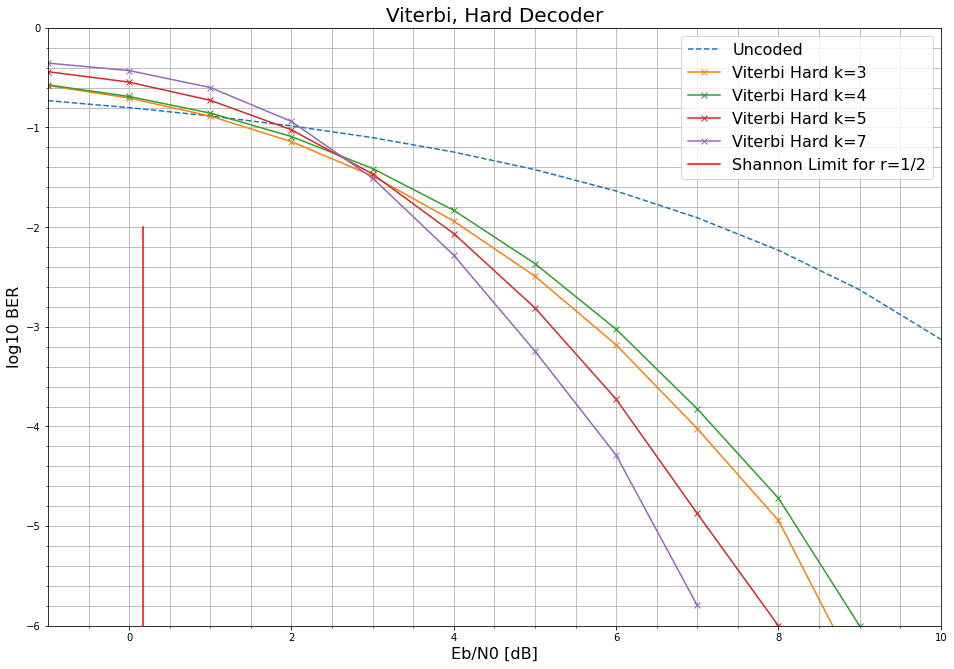

In [19]:
def plot_viterbi_hard(ax):
    # Viterbi (Hard Decision)
    for k in [3,4,5,7]:
        eb_n0, ber = viterbi[k]
        ax.plot(eb_n0, np.log10(ber), '-x', label=f"Viterbi Hard k={k}")
ber_plot(plot_viterbi_hard, title="Viterbi, Hard Decoder")

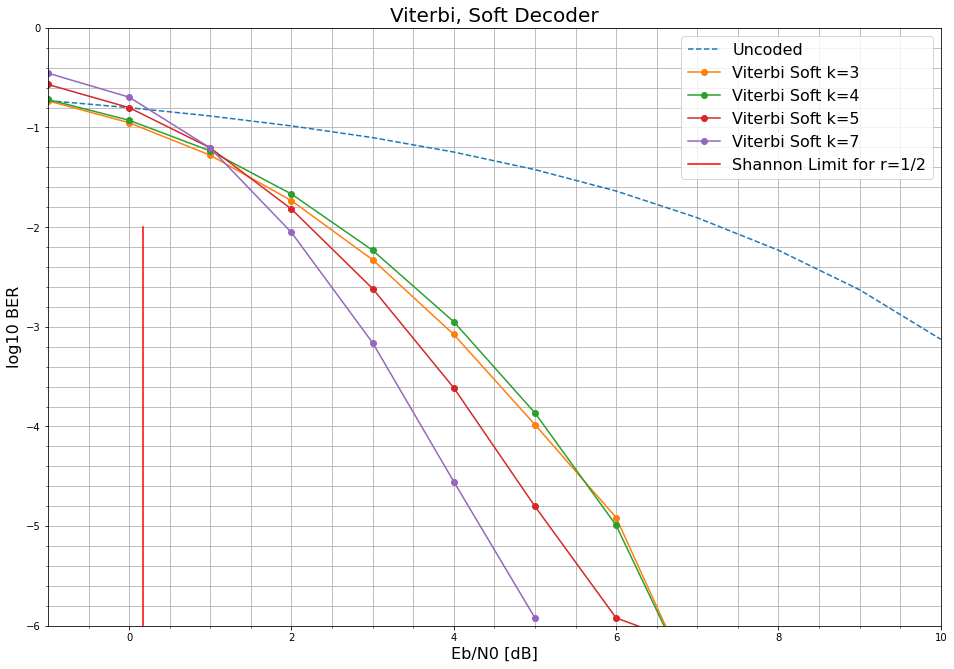

In [20]:
def plot_viterbi_soft(ax):
    # Viterbi (Soft Decision q = 4)
    for k in [3,4,5,7]:
        eb_n0, ber = viterbi_soft[k]
        ax.plot(eb_n0, np.log10(ber), '-o', label=f"Viterbi Soft k={k}")
ber_plot(plot_viterbi_soft, title="Viterbi, Soft Decoder")